<a href="https://colab.research.google.com/github/dkmau2004/Content/blob/main/Autoimmunity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Drug Induced Autoimmunity

In [1]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.9 MB/s eta 0:00:00


##Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from collections import Counter

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance, XGBClassifier

from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from scipy.stats import pointbiserialr

import shap

##Reading Files

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

##Analysing the Data

In [4]:
print("Dataset of train:")
display(train_df) #Showing the contents of the datasheet

Dataset of train:


Label                                             SMILES  BalabanJ  \
0        0  COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...     1.821   
1        0                    C[C@H](N(O)C(=O)N)c1cc2ccccc2s1     2.363   
2        0                              C[N+](C)(C)CC(=O)[O-]     3.551   
3        1  CC(C)n1c(\C=C\[C@H](O)C[C@H](O)CC(=O)O)c(c2ccc...     2.076   
4        1           C\C(=C(\C#N)/C(=O)Nc1ccc(cc1)C(F)(F)F)\O     2.888   
..     ...                                                ...       ...   
472      0                          C(C1=NCCN1)c2cccc3ccccc23     2.022   
473      0  C[N@+]1(CC2CC2)CC[C@]34[C@H]5Oc6c(O)ccc(C[C@@H...     1.602   
474      1  CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(=O)O...     1.766   
475      0   Clc1ccc(CO\N=C(\Cn2ccnc2)/c3ccc(Cl)cc3Cl)c(Cl)c1     1.831   
476      1  CCC[C@@]1(CCc2ccccc2)CC(=C([C@H](CC)c3cccc(c3)...     1.617   

      BertzCT    Chi0   Chi0n   Chi0v    Chi1   Chi1n   Chi1v  ...  \
0    1266.407  22.121  16.781  16.781  14.901   9.203   9.203  ...   
1     490.434  11.707   8.752   9.569   7.592   4.854   5.670  ...   
2      93.092   6.784   5.471   5.471   3.417   2.420   2.420  ...   
3    1053.003  21.836  16.995  16.995  14.274   9.926   9.926  ...   
4     549.823  14.629   9.746   9.746   8.752   5.040   5.040  ...   
..        ...     ...     ...     ...     ...     ...     ...  ...   
472   537.932  10.795   9.110   9.110   7.933   5.672   5.672  ...   
473   848.658  17.897  15.202  15.202  12.389  10.003  10.003  ...   
474   910.031  21.129  14.986  15.802  13.845   8.129   9.178  ...   
475   926.191  18.518  13.372  16.396  12.525   7.566   9.078  ...   
476  1565.385  30.545  23.226  24.043  19.871  13.658  15.098  ...   

     fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0             0             0           0                  0             0   
1             0             0           0                  0             0   
2             0             0           0                  0             0   
3             0             0           0                  0             0   
4             0             0           0                  0             0   
..          ...           ...         ...                ...           ...   
472           0             0           0                  0             0   
473           0             0           0                  0             0   
474           1             0           0                  0             0   
475           0             0           0                  0             0   
476           0             0           0                  0             0   

     fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0              0            0             0                 0        0  
1              0            0             1                 0        1  
2              0            0             0                 0        0  
3              0            0             0                 0        0  
4              0            0             0                 0        0  
..           ...          ...           ...               ...      ...  
472            0            0             0                 0        0  
473            0            0             0                 0        0  
474            0            0             0                 0        0  
475            0            0             0                 0        0  
476            0            0             0                 0        0  

[477 rows x 198 columns]

In [5]:
print("Dataset of test:")
display(test_df)

Dataset of test:


Label                                             SMILES  BalabanJ  \
0        0  C[C@H](\C=C\[C@H](O)C1CC1)[C@@H]2CC[C@@H]3\C(=...     1.484   
1        1     OCCN1CCN(CCCN2c3ccccc3Sc4ccc(cc24)C(F)(F)F)CC1     1.472   
2        0  C[C@@H]1O[C@H](C[C@H](O)[C@@H]1O)O[C@@H]2[C@H]...     0.837   
3        1                    NC(=O)Cc1cccc(C(=O)c2ccccc2)c1N     2.406   
4        0  COc1cc2c(CCN[C@]23CS[C@@H]4[C@@H]5[C@@H]6N(C)[...     1.320   
..     ...                                                ...       ...   
115      0  CCN1CCN(C(=O)N[C@H](C(=O)N[C@@H]2[C@@H]3SC(C)(...     1.508   
116      0                     CC1=C(C=C(C#N)C(=O)N1)c2ccncc2     2.678   
117      0              CCCN(CCc1cccs1)[C@@H]2CCc3c(O)cccc3C2     1.670   
118      0  COCCOC(=O)C1=C(C)NC(=C([C@@H]1c2cccc(c2)[N+](=...     2.603   
119      0                                    CCCCCCCCCCNCC=C     2.814   

      BertzCT    Chi0   Chi0n   Chi0v    Chi1   Chi1n   Chi1v  ...  \
0     743.207  21.466  18.764  18.764  14.292  12.106  12.106  ...   
1     868.947  21.140  16.736  17.553  14.453  10.268  11.084  ...   
2    1409.004  39.189  32.904  32.904  26.011  20.941  20.941  ...   
3     621.298  13.828  10.297  10.297   9.092   5.847   5.847  ...   
4    2127.996  37.955  30.849  31.666  25.910  18.066  19.115  ...   
..        ...     ...     ...     ...     ...     ...     ...  ...   
115  1127.109  26.361  19.925  20.742  16.973  11.450  12.330  ...   
116   608.396  11.544   8.689   8.689   7.720   4.765   4.765  ...   
117   593.488  15.364  13.294  14.110  10.775   8.338   9.217  ...   
118   902.371  22.422  17.683  17.683  14.167   9.469   9.469  ...   
119   109.803  10.485   9.856   9.856   6.914   6.231   6.231  ...   

     fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0             0             0           0                  0             0   
1             0             0           0                  0             0   
2             0             0           0                  0             0   
3             0             0           0                  0             0   
4             1             0           0                  0             0   
..          ...           ...         ...                ...           ...   
115           1             0           0                  0             0   
116           0             0           0                  0             0   
117           0             0           0                  0             0   
118           0             0           0                  0             0   
119           0             0           0                  0             0   

     fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0              0            0             0                 0        0  
1              0            0             0                 0        0  
2              0            0             0                 0        0  
3              0            0             0                 0        0  
4              0            0             0                 0        0  
..           ...          ...           ...               ...      ...  
115            0            0             0                 0        1  
116            0            0             0                 0        0  
117            0            0             1                 0        0  
118            0            0             0                 1        0  
119            0            0             0                 9        0  

[120 rows x 198 columns]

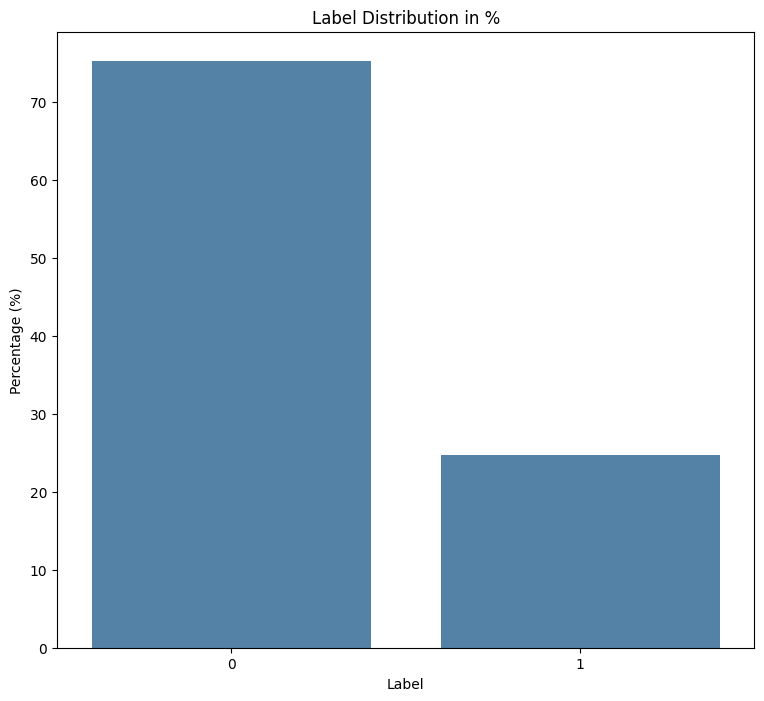

In [6]:
plt.figure(figsize=(9, 8))
sns.countplot(data=train_df, x="Label", stat="percent", color="steelblue")
plt.ylabel("Percentage (%)")
plt.xlabel("Label")
plt.title("Label Distribution in %")
plt.show()

###Correlation Analysis

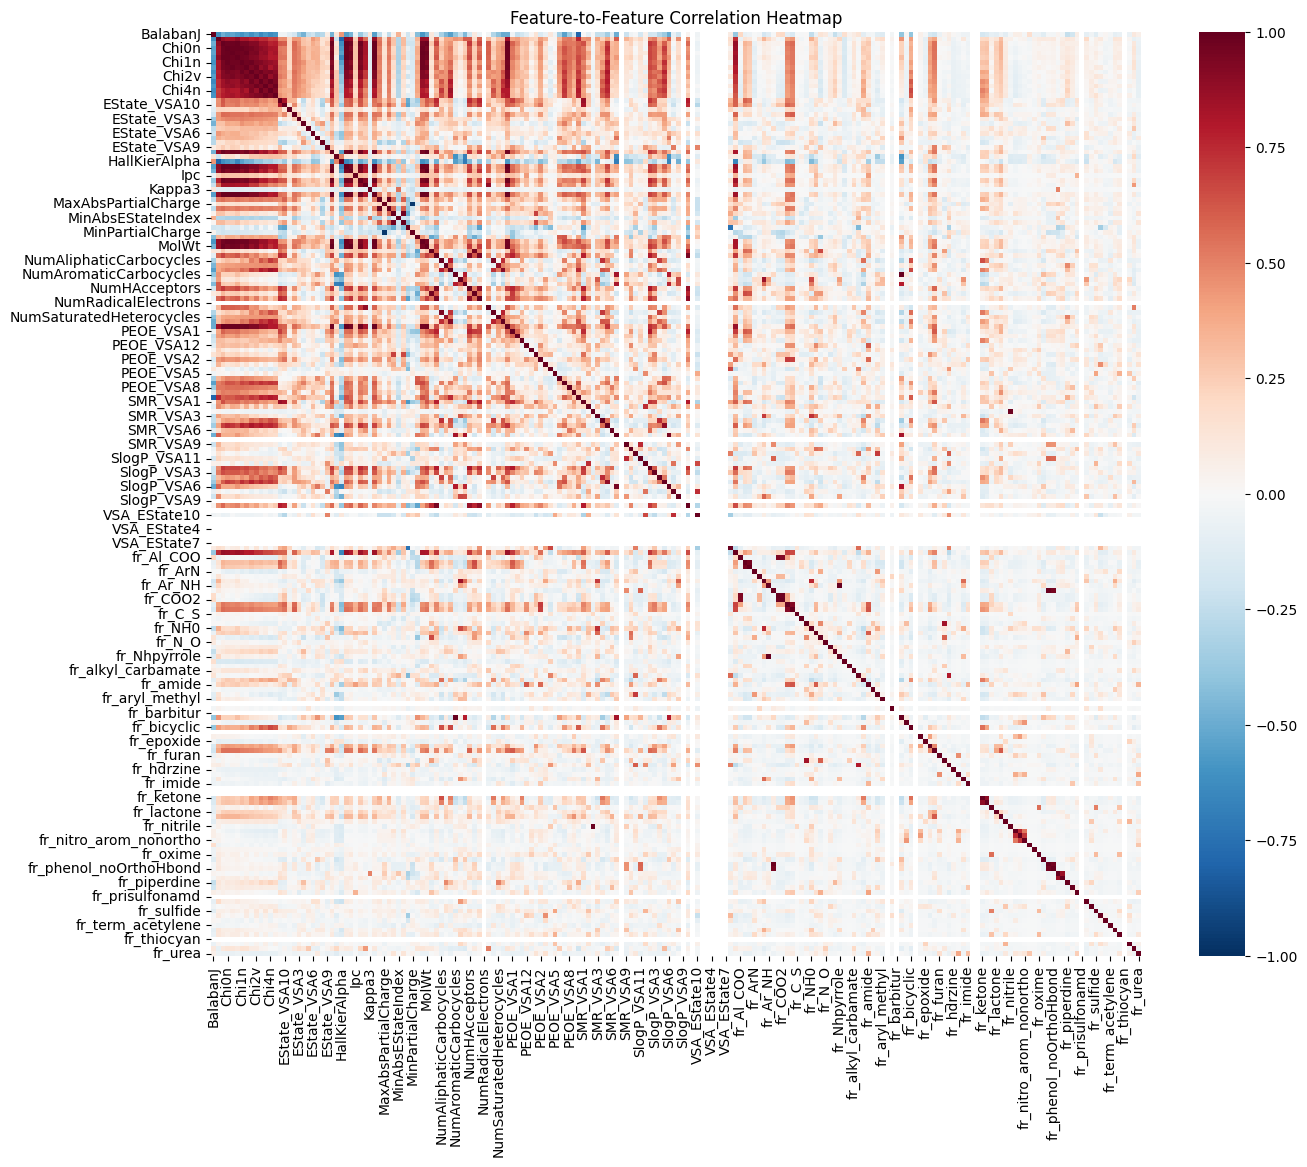

In [7]:
# Assume train_df contains all descriptors + 'Label'
corr = train_df.drop(columns=["SMILES", "Label"]).corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap="RdBu_r", center=0, vmax=1, vmin=-1)
plt.title("Feature-to-Feature Correlation Heatmap")
plt.show()

In [8]:
dropped_due_to_high_correlations = ["Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "NumSaturatedCarbocycles", "fr_Nhpyrrole", "MinAbsPartialCharge", "Chi2v", "Chi2n", "Chi3n", "MaxEStateIndex", "Chi3v", "Chi4n", "EState_VSA10", "Chi4v", "NumValenceElectrons", "SMR_VSA1", "VSA_EState9", "MolWt", "MolMR", "LabuteASA", "Kappa1", "HeavyAtomMolWt", "HeavyAtomCount", "ExactMolWt"]

In [9]:
cols_to_drop = ["SMILES"] + dropped_due_to_high_correlations

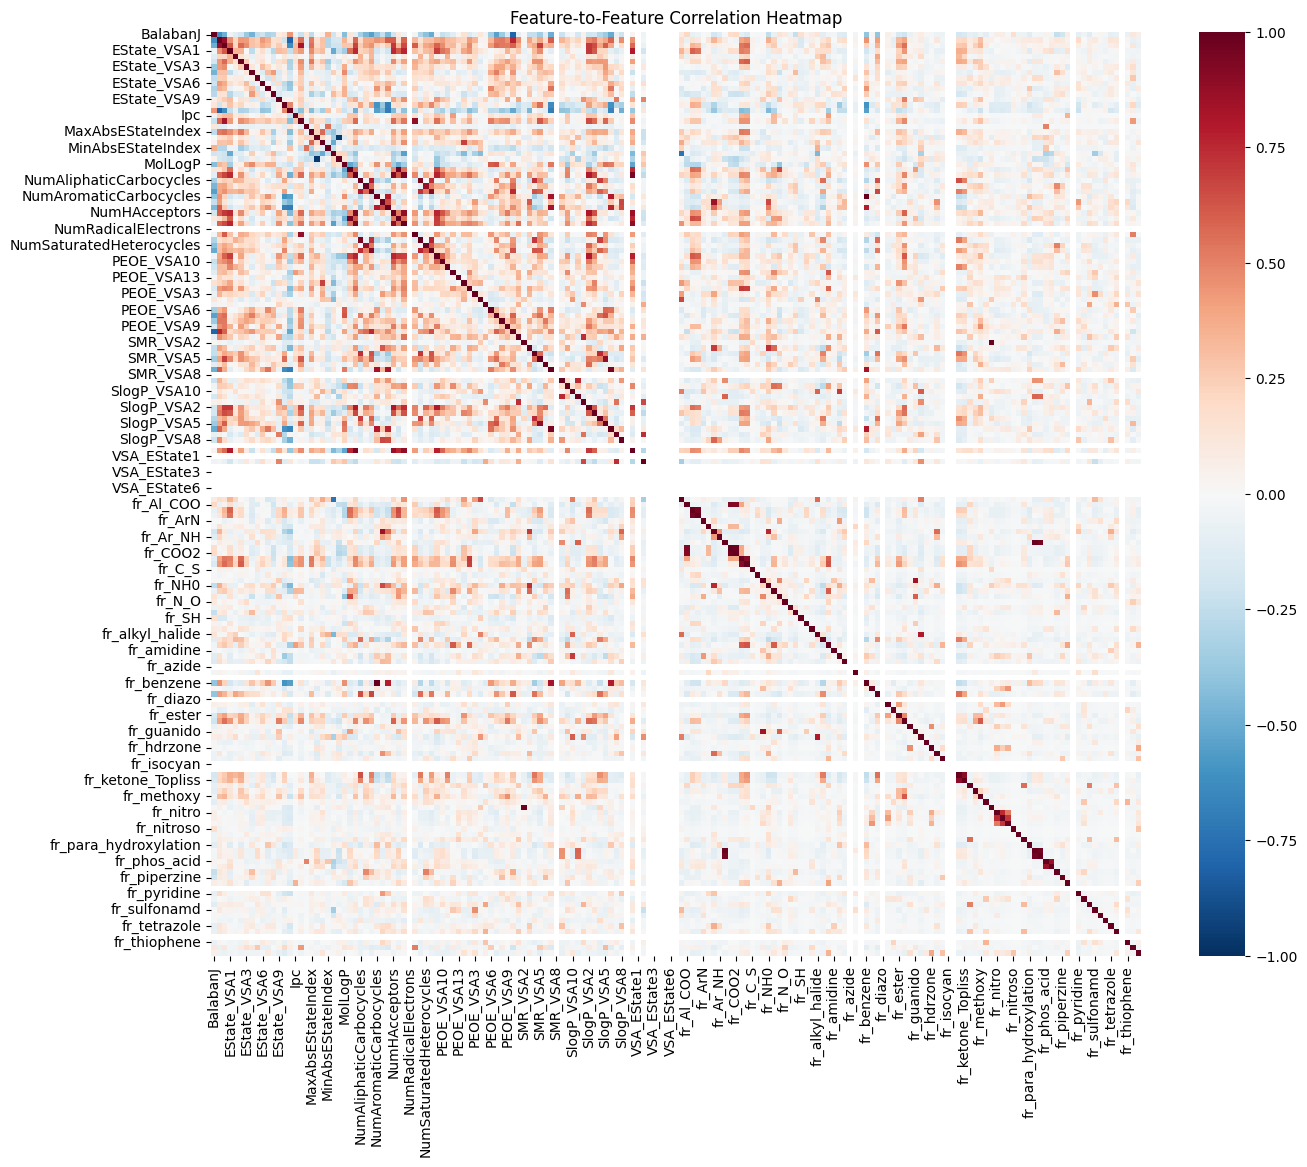

In [10]:
#Removing some of the highly correlated.
corr = train_df.drop(columns=["SMILES", "Label", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2v", "fr_Nhpyrrole", "MaxEStateIndex", "Chi2n", "MinAbsPartialCharge", "EState_VSA10", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "NumValenceElectrons", "SMR_VSA1", "VSA_EState9", "MolWt", "MolMR", "LabuteASA", "Kappa1", "HeavyAtomMolWt", "HeavyAtomCount", "ExactMolWt"]).corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap="RdBu_r", center=0, vmax=1, vmin=-1)
plt.title("Feature-to-Feature Correlation Heatmap")
plt.show()

In [11]:
corr.corr().style.background_gradient(cmap='viridis')

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [12]:
corr2 = train_df.drop(columns=["SMILES", "Label", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "fr_Nhpyrrole", "Chi2v", "NumSaturatedCarbocycles", "MaxEStateIndex", "Chi2n", "MinAbsPartialCharge", "EState_VSA10", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "NumValenceElectrons", "SMR_VSA1", "VSA_EState9", "MolWt", "MolMR", "LabuteASA", "Kappa1", "HeavyAtomMolWt", "HeavyAtomCount", "ExactMolWt"]).corr()

In [13]:
corr2.corr().style.background_gradient(cmap='viridis')

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


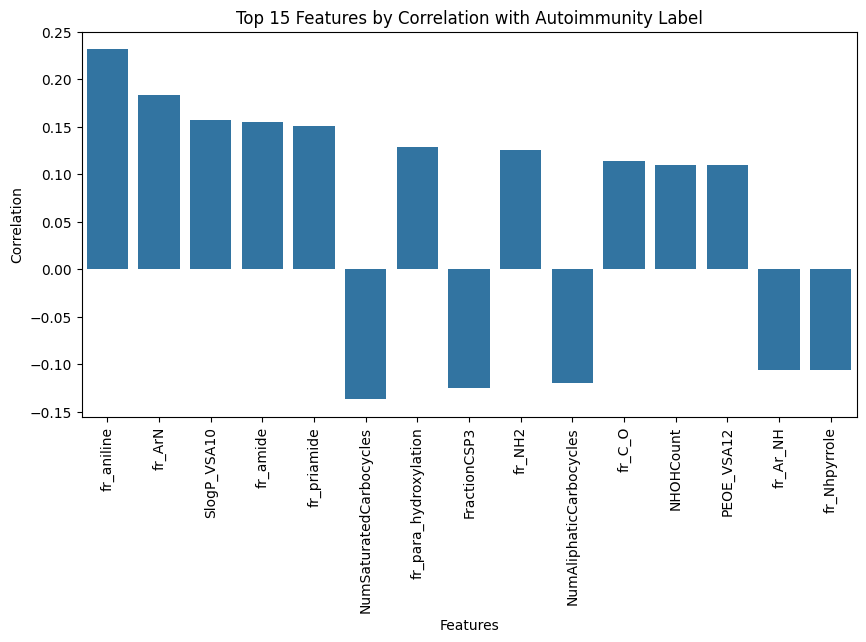

In [14]:
# Correlation with the binary target
feature_cols = train_df.columns.difference(["SMILES", "Label"])
corr_target = {col: pointbiserialr(train_df[col], train_df["Label"])[0] for col in feature_cols}
corr_series = pd.Series(corr_target).sort_values(key=lambda x: abs(x), ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=corr_series.index[:15], y=corr_series.values[:15])
plt.xticks(rotation=90)
plt.title("Top 15 Features by Correlation with Autoimmunity Label")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.show()


/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


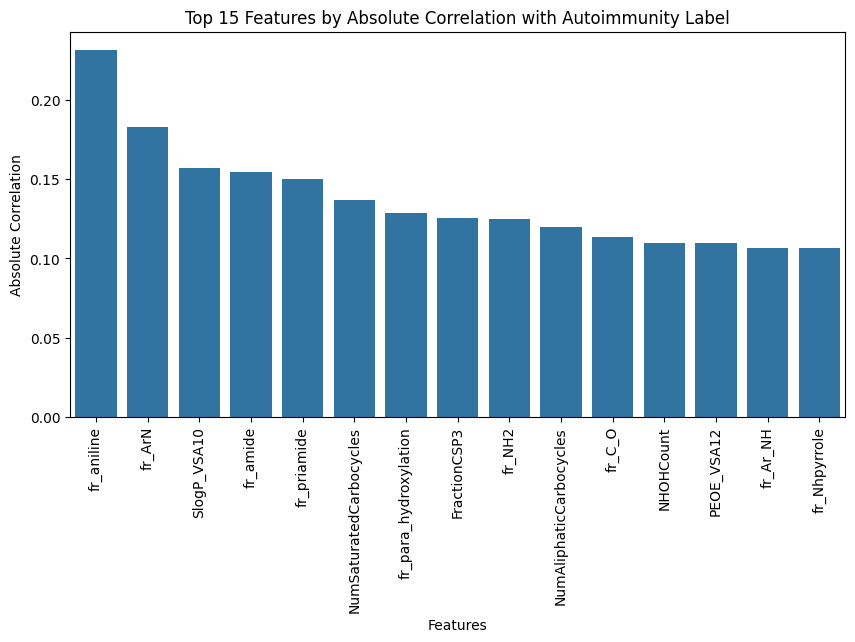

In [15]:
# Compute absolute point-biserial correlation
corr_target = {
    col: abs(pointbiserialr(train_df[col], train_df["Label"])[0])
    for col in feature_cols
}

# Sort by strongest relationship
corr_series = pd.Series(corr_target).sort_values(ascending=False)

# Top 20 features
plt.figure(figsize=(10, 5))
sns.barplot(x=corr_series.index[:15], y=corr_series.values[:15])
plt.xticks(rotation=90)
plt.title("Top 15 Features by Absolute Correlation with Autoimmunity Label")
plt.xlabel("Features")
plt.ylabel("Absolute Correlation")
plt.show()

This show that fr_aniline has the greatest correlation with drug induced autoimmunity.

### Distribution of some features

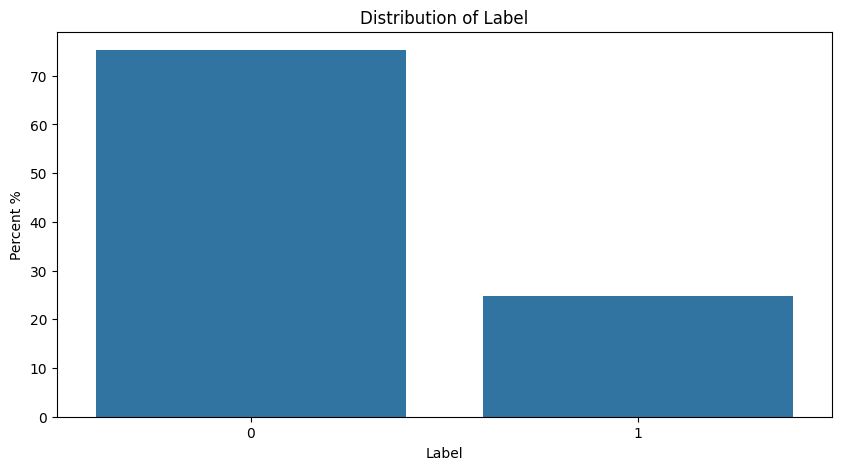

In [16]:
plt.figure(figsize=(10, 5))
plt.xlabel("Label")
plt.ylabel("Percent %")
plt.title("Distribution of Label")
sns.countplot(data=train_df,x='Label', stat= 'percent')
plt.show()

There's more 0 than 1 therefore the model needs to be imputed with data that has 1 so that the model wouldn't prioritise 0 over 1.

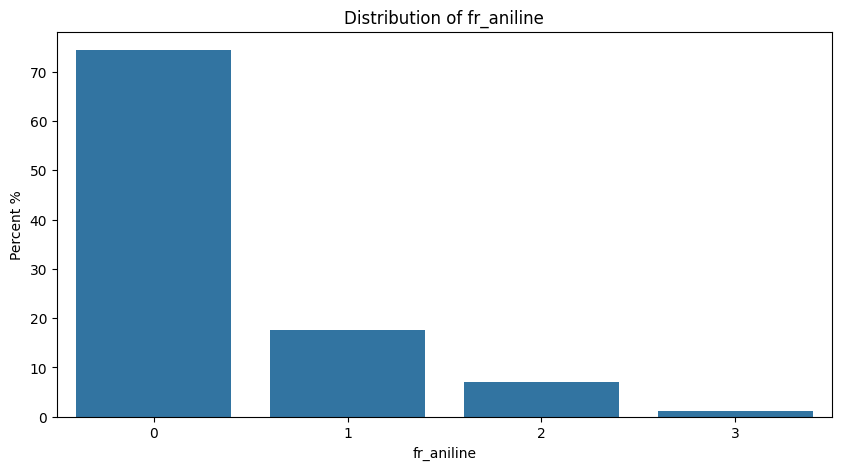

In [17]:
plt.figure(figsize=(10, 5))
plt.xlabel("fr_aniline")
plt.ylabel("Percent %")
plt.title("Distribution of fr_aniline")
sns.countplot(data=train_df,x='fr_aniline', stat= 'percent')
plt.show()

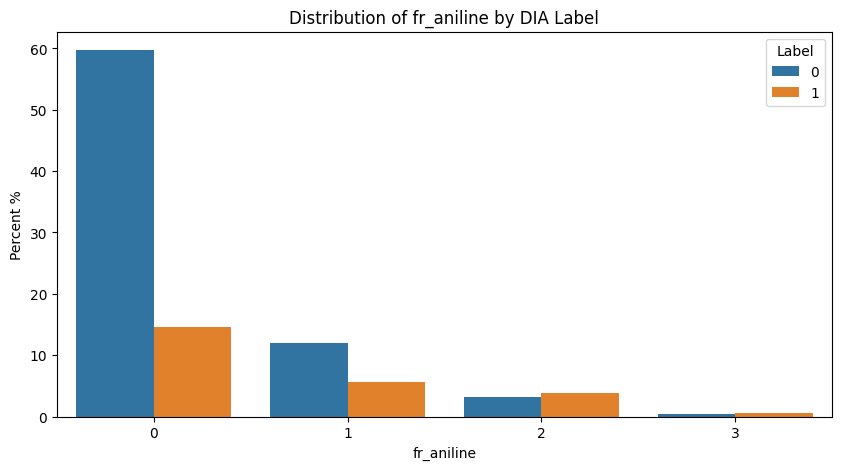

In [18]:
# Count plot for fr_aniline
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df,x='fr_aniline',hue='Label', stat='percent')
plt.xlabel("fr_aniline")
plt.ylabel("Percent %")
plt.title("Distribution of fr_aniline by DIA Label")
plt.show()

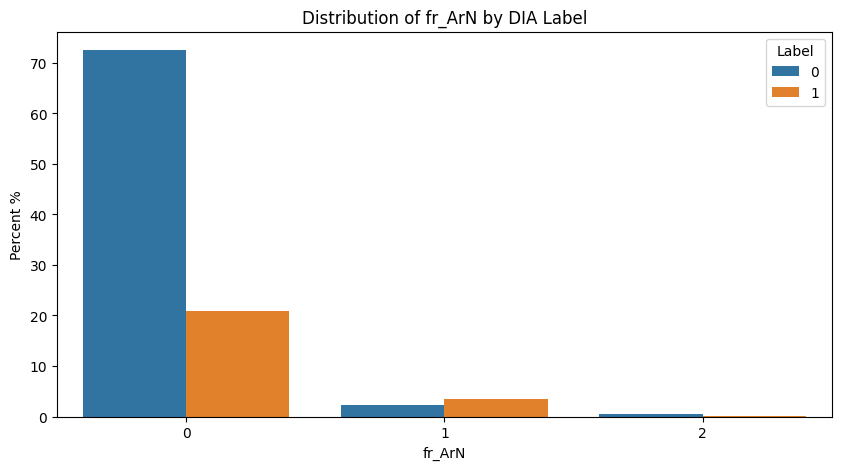

In [19]:
# Count plot for fr_ArN
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df,x='fr_ArN',hue='Label', stat='percent')
plt.xlabel("fr_ArN")
plt.ylabel("Percent %")
plt.title("Distribution of fr_ArN by DIA Label")
plt.show()

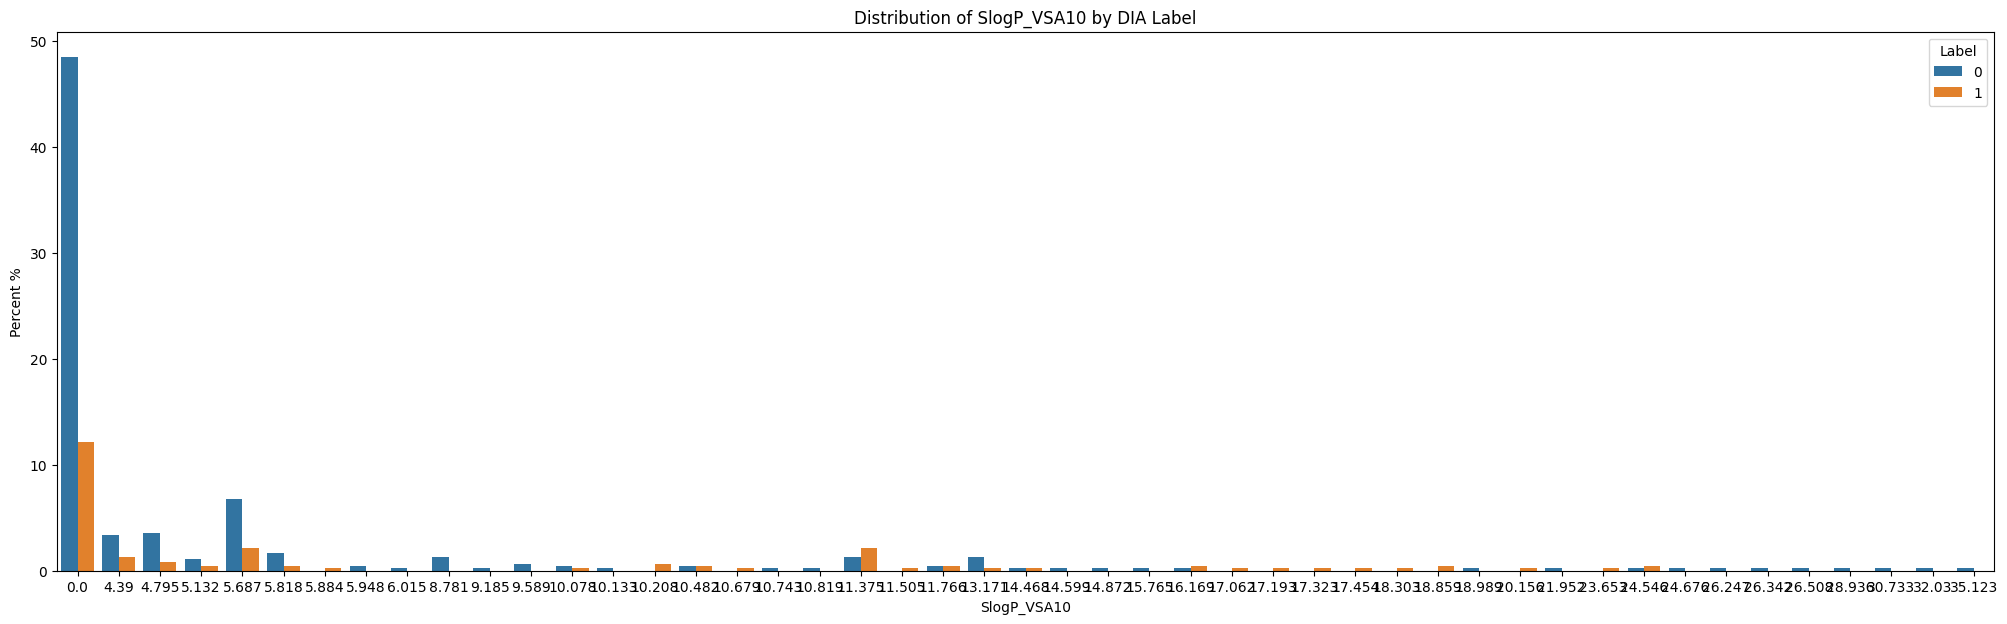

In [20]:
# Count plot for SlogP_VSA10
plt.figure(figsize=(25, 7))
sns.countplot(data=train_df,x='SlogP_VSA10',hue='Label', stat='percent')
plt.xlabel("SlogP_VSA10")
plt.ylabel("Percent %")
plt.title("Distribution of SlogP_VSA10 by DIA Label")
plt.show()

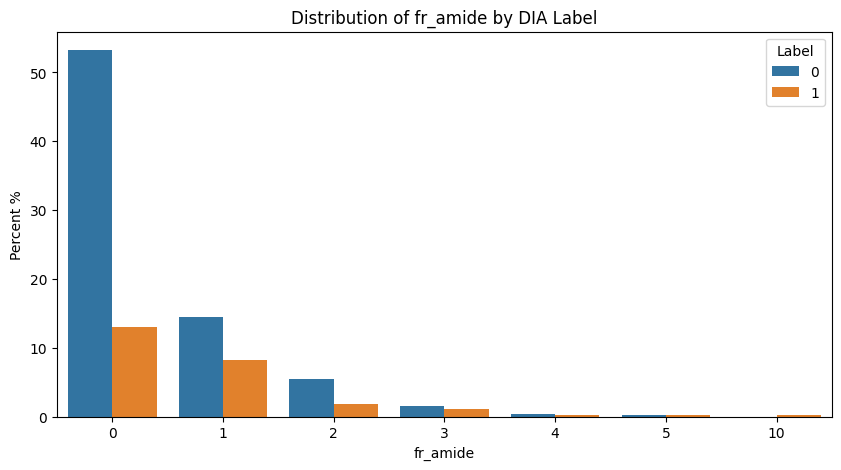

In [21]:
# Count plot for fr_amide
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df,x='fr_amide',hue='Label', stat='percent')
plt.xlabel("fr_amide")
plt.ylabel("Percent %")
plt.title("Distribution of fr_amide by DIA Label")
plt.show()

## XGBoost Modelling

In [22]:
# Separate features and labels
train_df= train_df.drop(columns= cols_to_drop)
test_df= test_df.drop(columns= cols_to_drop)
X_train = train_df.drop("Label", axis=1)
y_train = train_df["Label"]

X_test = test_df.drop("Label", axis=1)
y_test = test_df["Label"]

### SMOTE

In [23]:

# Before SMOTE
print("Original class distribution:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# After SMOTE
print("Resampled class distribution:", Counter(y_resampled))

Original class distribution: Counter({0: 359, 1: 118})
Resampled class distribution: Counter({0: 359, 1: 359})


In [24]:
# xgb_param_grid = {
#     'learning_rate': Real(0.01, 0.2, prior='uniform'),
#     'n_estimators': Integer(100, 300),
#     'max_depth': Integer(1, 10),
#     'min_child_weight': Integer(1, 2),
#     'subsample': Real(0.1, 0.3, prior='uniform'),
#     'colsample_bytree': Real(0.6, 0.9, prior='uniform'),
#     'gamma': Real(0.01, 1, prior='uniform'),
#     'scale_pos_weight': Integer(0, 3)
# }

# xgb_class = BayesSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
#                             search_spaces=xgb_param_grid,
#                             n_iter=150,
#                             cv=5,
#                             verbose=True,
#                             n_jobs=-1,
#                             random_state=42)


# xgb_class.fit(X_resampled, y_resampled)

### Hyperparameter Tuning

In [25]:
xgb_param_grid = {
    'learning_rate': Real(0.01, 0.3, prior='uniform'),
    'n_estimators': Integer(20, 80),
    'max_depth': Integer(3, 7),
    'min_child_weight': Integer(1, 3),
    'lambda': Real(0.01, 10, prior='uniform'),
    'alpha': Real(0.01, 10, prior='uniform'),
    #'subsample': Real(0.7, 0.95, prior='uniform'),
    #'colsample_bytree': Real(0.6, 0.9, prior='uniform'),
    #'gamma': Real(0.01, 2, prior='uniform'),
    #'scale_pos_weight': Integer(0, 3)
}

xgb_class = BayesSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", subsample=0.9, gamma=0.5),
                            search_spaces=xgb_param_grid,
                            n_iter=100,
                            cv=5,
                            verbose=True,
                            n_jobs=-1,
                            random_state=42)


xgb_class.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:55:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      feature_weights=None, gamma=0.5,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraint...
                             'lambda': Real(low=0.01, high=10, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=7, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=3, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=20, high=80, prior='uniform', transform='normalize')},
              verbose=True)

In [26]:
# Get the best hyperparameters from RandomizedSearchCV for XGBoost
best_params_xgb = xgb_class.best_params_

print("Best Hyperparameters for XGBoost:")
for param, value in best_params_xgb.items():
    print(f"  {param}: {value}")

Best Hyperparameters for XGBoost:
  alpha: 0.01
  lambda: 0.01
  learning_rate: 0.11537467989365575
  max_depth: 5
  min_child_weight: 1
  n_estimators: 73


### Predictions

In [27]:
# Predict on the test set
y_pred = xgb_class.predict(X_test)

# Evaluate performance
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

# Extra: Detailed report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Extra: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

Accuracy : 0.8416666666666667
Precision: 0.7894736842105263
Recall   : 0.5
F1 Score : 0.6122448979591837

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90        90
           1       0.79      0.50      0.61        30

    accuracy                           0.84       120
   macro avg       0.82      0.73      0.76       120
weighted avg       0.84      0.84      0.83       120


Confusion Matrix:
 [[86  4]
 [15 15]]


In [28]:
from sklearn.metrics import roc_auc_score

# Compute AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)


AUC: 0.7277777777777777


In [29]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred)
print("MCC:", mcc)


MCC: 0.5403631715156483
